In [1]:
# Core libraries
import numpy as np
import pandas as pd
import os
import inspect
import json
from pathlib import Path
from IPython.display import display, HTML

# Machine learning
import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             balanced_accuracy_score, log_loss,
                             mean_squared_error, make_scorer,
                             precision_recall_curve, confusion_matrix, matthews_corrcoef)
from sklearn.inspection import permutation_importance

# Hyperparameter tuning
import optuna
# 1) Silence Optuna’s default trial‐completion logs
optuna.logging.set_verbosity(optuna.logging.WARNING)      # only WARN and above
optuna.logging.disable_default_handler()                   # remove the stderr handler

# Explainability
import shap
try:
    from lime.lime_tabular import LimeTabularExplainer
    _lime_available = True
except ImportError:
    _lime_available = False
    print("Warning: LIME not installed. Run `pip install lime` to enable LIME explanations.")
import lime
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# System
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

class TqdmCallback:
    def __init__(self, total):
        self.bar = tqdm(total=total, desc="Trials", position=2, leave=False)
    def __call__(self, study, trial):
        self.bar.update(1)
    def close(self):
        self.bar.close()

# Constants

In [6]:
DATA_CSV      = "..\data\df_2022_2024.csv"
OUT_DIR       = "ancillary_models"

TARGETS =  [
    'Price_positive_secondary',
    'Price_negative_secondary',
    'Price_positive_tertiary',
    'Price_negative_tertiary'
]

LABEL_METHOD  = "fixed"         # {"fixed","rolling","dynamic"}
TWO_SIDED     = True              # detect negative spikes too ?
LABEL_MODE    = "binary_extreme"  # or "three_class"

P_HI, P_LO    = 95, 5
ROLL_WINDOW   = 24*7
K_SIGMA       = 1

N_SPLITS      = 5
N_TRIALS      = 40
# N_TRIALS      = 2
EARLY_STOP = 30
GPU_TREE      = True

# Load Data

In [7]:
#Load data
data = pd.read_csv(DATA_CSV)
data.index = pd.date_range(start='2022-11-01', periods=len(data), freq='H')

data = data.loc['2023-01-01':'2024-01-14'].copy()

# Define features
features = [col for col in data.columns if col not in TARGETS]

# Fill missing values
data.fillna(method='ffill', inplace=True)

# Label Generation

In [4]:
def make_labels(series, method=LABEL_METHOD, two_sided=TWO_SIDED, mode=LABEL_MODE,
                percentile_high=P_HI, percentile_low=P_LO, roll_window=ROLL_WINDOW, k=K_SIGMA):
    if method == "fixed":
        hi, lo = np.percentile(series, percentile_high), np.percentile(series, percentile_low)
        up, low = series >= hi, series <= lo if two_sided else None
    elif method == "rolling":
        hi = series.rolling(roll_window).quantile(percentile_high/100)
        lo = series.rolling(roll_window).quantile(percentile_low/100)
        up, low = series >= hi, series <= lo if two_sided else None
    elif method == "dynamic":
        mu, sd = series.rolling(roll_window).mean(), series.rolling(roll_window).std()
        up, low = series >= mu+k*sd, series <= mu-k*sd if two_sided else None
    else:
        raise ValueError("method must be fixed/rolling/dynamic")

    lbl = np.where(up, 1, np.where(low, -1, 0)) if two_sided else up.astype(int)
    if mode == "binary_extreme":
        return pd.Series((lbl != 0).astype(int), index=series.index)  # <- Series!
    elif mode == "three_class":
        return pd.Series(lbl, index=series.index)
    else:
        raise ValueError("mode must be 'binary_extreme' or 'three_class'")

## Pseudo $R^2$

# Seasonal and non seasonal features

In [5]:
def add_lags(d, col, lags=(1,24,168)):
    for L in lags: d[f"{col}_lag_{L}"] = d[col].shift(L)
    return d

def add_rolls(d, col, wins=(24,168)):
    for W in wins:
        d[f"{col}_mean_{W}"] = d[col].rolling(W).mean()
        d[f"{col}_std_{W}"]  = d[col].rolling(W).std()
        d[f"{col}_max_{W}"]  = d[col].rolling(W).max()
    return d

def build_features(df, tgt):
    return add_rolls(add_lags(df.copy(), tgt), tgt).dropna()

In [6]:
def mc_fadden_r2(m,X,y):
    ll_full = -log_loss(y, m.predict_proba(X)[:,1], normalize=False)
    ll_null = -log_loss(y, np.full_like(y, y.mean()), normalize=False)
    return 1 - ll_full/ll_null
def tjur_r2(m,X,y):
    p = m.predict_proba(X)[:,1]
    return p[y==1].mean() - p[y==0].mean()

# Parameters tuning

In [7]:
def objective(trial, X_train, y_train, X_val, y_val, ratio, gpu_tree=True):
    params = dict(
        tree_method = "gpu_hist" if gpu_tree else "hist",
        objective   = "binary:logistic",
        eval_metric = "logloss",
        learning_rate   = trial.suggest_float("lr", 0.005, 0.3, log=True),
        max_depth       = trial.suggest_int ("depth", 3, 12),
        min_child_weight= trial.suggest_int ("mcw", 1, 10),
        subsample       = trial.suggest_float("sub", 0.3, 1.0),
        colsample_bytree= trial.suggest_float("col", 0.2, 1.0),
        reg_alpha       = trial.suggest_float("alpha", 1e-3, 1),
        reg_lambda      = trial.suggest_float("lam",   1e-3, 1),
        scale_pos_weight= trial.suggest_float("spw", ratio*0.8, ratio*1.2),
        n_estimators    = trial.suggest_categorical("n", [200, 400, 800])
    )

    model = xgb.XGBClassifier(**params, early_stopping_rounds=EARLY_STOP)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False)
    preds = model.predict(X_val)
    mcc = matthews_corrcoef(y_val, preds)
    return 1 - f1_score(y_val, preds)

# Training

### Training loop

In [ ]:
def train_all_thresholds(
        method: str,                    # "fixed" | "rolling" | "dynamic"
        two_sided: bool = True,
        label_mode: str = "binary_extreme",
        n_splits: int = N_SPLITS,
        n_trials: int = N_TRIALS,
        gpu_tree: bool = GPU_TREE,
) -> dict:
    """Return {target: best_fold_dict} for the chosen label scheme."""

    df = data.copy()

    # If you want lags/rolling later, just uncomment build_features
    # df = add_rolls(add_lags(df), target)

    df["Date"] = pd.to_datetime(df["Date"])
    df["hour"]     = df["Date"].dt.hour
    df["weekday"]  = df["Date"].dt.weekday
    df = df.drop(columns="Date")

    best_folds = {}
    tscv       = TimeSeriesSplit(n_splits=n_splits)

    for target in tqdm(TARGETS, desc="Targets", position=0):
        df_obj = add_rolls(add_lags(df, target), target)
        X  = df_obj.drop(columns=TARGETS)
        y  = make_labels(df_obj[target], method=method,
                         two_sided=two_sided, mode=label_mode)
        y, X = y.align(X, join="inner", axis=0)

        folds  = []
        splits = list(tscv.split(X))

        
        # spikes = y.sum()                             
        # ratio  = np.inf if spikes == 0 else (len(y) - spikes) / spikes
        # ratio = max(1.0, min(100.0, (len(y_tr) - spikes) / spikes))  if spikes else 1.0


        for fold, (tr_idx, va_idx) in enumerate(
                tqdm(splits, desc="Folds", position=1, leave=False), start=1):

            X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
            y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
            
            spikes = int(y_tr.sum())
            ratio  = 1.0 if spikes == 0 else min(100, (len(y_tr)-spikes)/spikes)

            # Optuna search with custom tqdm callback
            study   = optuna.create_study(direction="maximize")
            pbar_cb = TqdmCallback(n_trials)
            study.optimize(
                lambda t: objective(
                    t, X_tr, y_tr, X_va, y_va, ratio, gpu_tree=gpu_tree),
                n_trials=n_trials,
                callbacks=[pbar_cb],
                show_progress_bar=False,
            )
            pbar_cb.close()

            def sanitize(params, max_depth_cap=15, spw_cap=100):
                """Keep hyper-parameters in a range XGBoost can handle."""
                params["max_depth"] = min(params.get("max_depth", 6), max_depth_cap)
                # scale_pos_weight: limit to avoid overflow when spikes=0
                spw = params.get("scale_pos_weight", 1)
                params["scale_pos_weight"] = min(spw_cap, max(1, spw))
                return params

            best_params = sanitize(study.best_trial.params)
            model = xgb.XGBClassifier(**best_params,
                                      early_stopping_rounds=EARLY_STOP)
            model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

            preds = model.predict(X_va)
            folds.append({
                "fold": fold,
                "model": model,
                "X_va": X_va,
                "y_va": y_va,
                "preds": preds,
                "best_params": best_params,
                "precision": precision_score(y_va, preds, zero_division=0),
                "recall":    recall_score(y_va, preds, zero_division=0),
                "f1":        f1_score(y_va, preds,  zero_division=0),
                "confusion_matrix": confusion_matrix(y_va, preds),
                "ratio": ratio
            })

        if folds:
            best_folds[target] = max(folds, key=lambda f: f["f1"])
            print(f"Best MCC for {target} [{method}]: {best_folds[target]['f1']:.4f}")
        else:
            print(f"No valid folds for {target}.")

    return best_folds


### Train all methods

In [10]:
best_fixed    = train_all_thresholds(method="fixed")

Targets:   0%|          | 0/4 [00:00<?, ?it/s]

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/2 [00:00<?, ?it/s]

Trials:   0%|          | 0/2 [00:00<?, ?it/s]

Trials:   0%|          | 0/2 [00:00<?, ?it/s]

Trials:   0%|          | 0/2 [00:00<?, ?it/s]

Trials:   0%|          | 0/2 [00:00<?, ?it/s]

Best F1 for Price_positive_secondary [fixed]: 0.9672


Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/2 [00:00<?, ?it/s]

Trials:   0%|          | 0/2 [00:00<?, ?it/s]

Trials:   0%|          | 0/2 [00:00<?, ?it/s]

Trials:   0%|          | 0/2 [00:00<?, ?it/s]

Trials:   0%|          | 0/2 [00:00<?, ?it/s]

Best F1 for Price_negative_secondary [fixed]: 0.6690


Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/2 [00:00<?, ?it/s]

Trials:   0%|          | 0/2 [00:00<?, ?it/s]

Trials:   0%|          | 0/2 [00:00<?, ?it/s]

Trials:   0%|          | 0/2 [00:00<?, ?it/s]

Trials:   0%|          | 0/2 [00:00<?, ?it/s]

Best F1 for Price_positive_tertiary [fixed]: 0.9883


Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/2 [00:00<?, ?it/s]

Trials:   0%|          | 0/2 [00:00<?, ?it/s]

Trials:   0%|          | 0/2 [00:00<?, ?it/s]

Trials:   0%|          | 0/2 [00:00<?, ?it/s]

Trials:   0%|          | 0/2 [00:00<?, ?it/s]

Best F1 for Price_negative_tertiary [fixed]: 0.9826


In [29]:
best_rolling  = train_all_thresholds(method="rolling")

Targets:   0%|          | 0/4 [00:00<?, ?it/s]

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Best F1 for Price_positive_secondary [rolling]: 0.9423


Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Best F1 for Price_negative_secondary [rolling]: 0.4861


Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Best F1 for Price_positive_tertiary [rolling]: 0.9563


Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Best F1 for Price_negative_tertiary [rolling]: 0.9338


In [30]:
best_dynamic  = train_all_thresholds(method="dynamic")

Targets:   0%|          | 0/4 [00:00<?, ?it/s]

Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Best F1 for Price_positive_secondary [dynamic]: 0.9110


Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Best F1 for Price_negative_secondary [dynamic]: 0.6554


Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Best F1 for Price_positive_tertiary [dynamic]: 0.7376


Folds:   0%|          | 0/5 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Trials:   0%|          | 0/40 [00:00<?, ?it/s]

Best F1 for Price_negative_tertiary [dynamic]: 0.8250


# Evaluation

## Helper

In [31]:
def _safe_rmse(y_true, y_pred):
    """
    Square-root of MSE, but tolerant to old sklearn that
    didn't yet support the `squared` kw-arg.
    """
    if "squared" in inspect.signature(mean_squared_error).parameters:
        # modern sklearn (≥ 0.24) – we can ask for raw MSE
        mse = mean_squared_error(y_true, y_pred, squared=True)
    else:
        # legacy: function only returns MSE; no `squared` keyword
        mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)

rmse_scorer = make_scorer(_safe_rmse, greater_is_better=False)

def xgb_gain_plot(model, top=10):
    xgb.plot_importance(model.get_booster(), importance_type="gain", max_num_features=top)
    plt.title("XGBoost Gain Importance")
    plt.show()

def perm_rmse_plot(model, X_val, y_val, top=10):
    r = permutation_importance(model, X_val, y_val, scoring=rmse_scorer, n_repeats=5, random_state=0,
                               n_jobs=-1)
    idx = np.argsort(-r.importances_mean)[:top]
    plt.barh(X_val.columns[idx], -r.importances_mean[idx])
    plt.gca().invert_yaxis()
    plt.title("Permutation Importance (ΔRMSE)")
    plt.show()

def shap_plots(model, X_val):
    expl = shap.TreeExplainer(model)
    sv = expl.shap_values(X_val)
    shap.summary_plot(sv, X_val, plot_type="bar"); plt.show()
    shap.summary_plot(sv, X_val); plt.show()

def lime_local(model, X_tr, X_val, n_feat=8):
    exp = LimeTabularExplainer(
        X_tr.values,
        feature_names=X_tr.columns,
        class_names=["no_spike", "spike"],
        mode="classification",
    ).explain_instance(
        X_val.iloc[-1].values,
        model.predict_proba,
        num_features=n_feat,
    )

    # ── grab lime.css (or minimal fallback) ──
    css_path = Path(lime.__file__).with_name("lime.css")
    css = css_path.read_text() if css_path.exists() else """
        body{background:#333;color:#eee;font-family:sans-serif}
        th,td{padding:4px 8px;border:1px solid #555;font-size:12px}
        .lime{background:#1f77b4;color:#fff}
        .lime_neg{background:#ff7f0e;color:#fff}"""
    
    # css += """
    # body      { background:#1f2a44; margin:0; }
    # .lime-table table { width:90%; margin:auto; }
    # .lime-table th    { font-size:14px; }
    # .lime-table td    { font-size:13px; }
    # """

    html = exp.as_html().replace("</head>", f"<style>{css}</style></head>")
    display(HTML(html))


def precision_recall_curve_plot(y_val, proba):
    prec, rec, _ = precision_recall_curve(y_val, proba)
    plt.plot(rec, prec)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.show()

def evaluate_model(fold_dict):
    m   = fold_dict["model"]
    Xv  = fold_dict["X_va"]
    yv  = fold_dict["y_va"]
    preds = fold_dict["preds"]

    print(f" Precision: {precision_score(yv, preds):.3f}"
          f"  Recall: {recall_score(yv, preds):.3f}"
          f"  F1: {f1_score(yv, preds):.3f}")
    print(f" BalancedAcc: {balanced_accuracy_score(yv, preds):.3f}"
          f"  McFaddenR²: {mc_fadden_r2(m, Xv, yv):.3f}"
          f"  TjurR²: {tjur_r2(m, Xv, yv):.3f}")
    xgb_gain_plot(m)
    perm_rmse_plot(m, Xv, yv)
    shap_plots(m, Xv)
    # lime_local(m, fold_dict["X_tr"], fold_dict["X_va"])
    precision_recall_curve_plot(yv, m.predict_proba(Xv)[:, 1])

def evaluate_all(best_folds: dict):
    for tgt, fld in best_folds.items():
        print(f"\n=== {tgt} ===")
        evaluate_model(fld)

## Evaluate fixed


=== Price_positive_secondary ===
 Precision: 0.963  Recall: 0.963  F1: 0.963
 BalancedAcc: 0.976  McFaddenR²: 0.993  TjurR²: 0.912


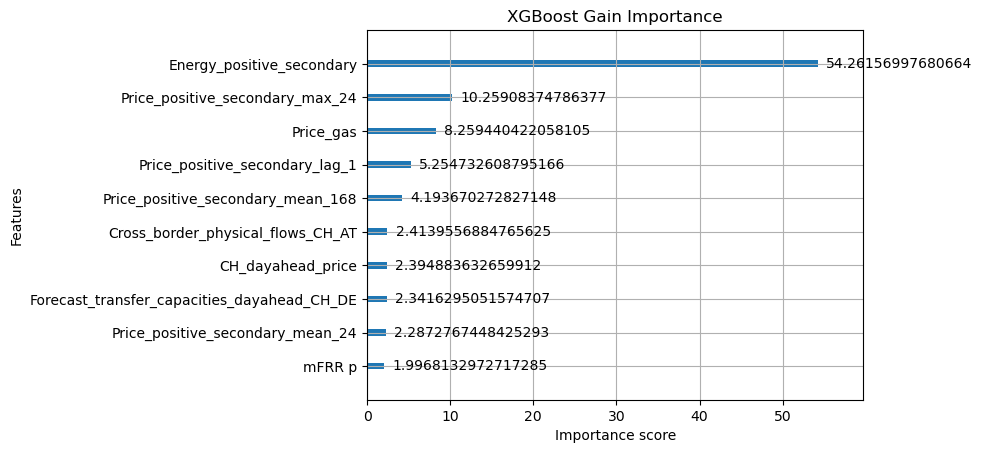

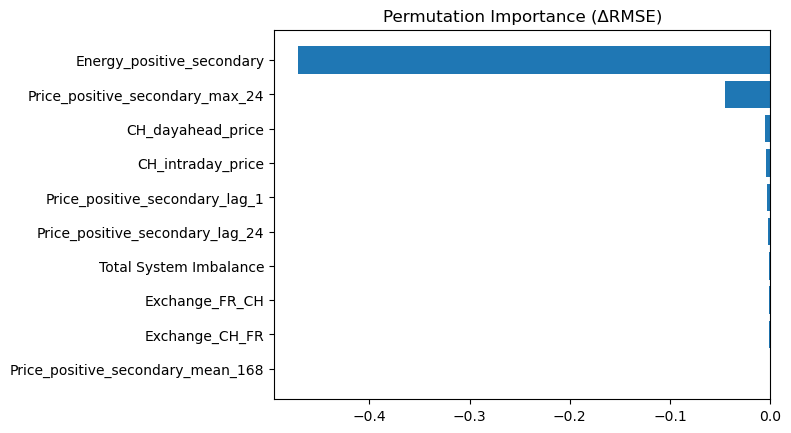

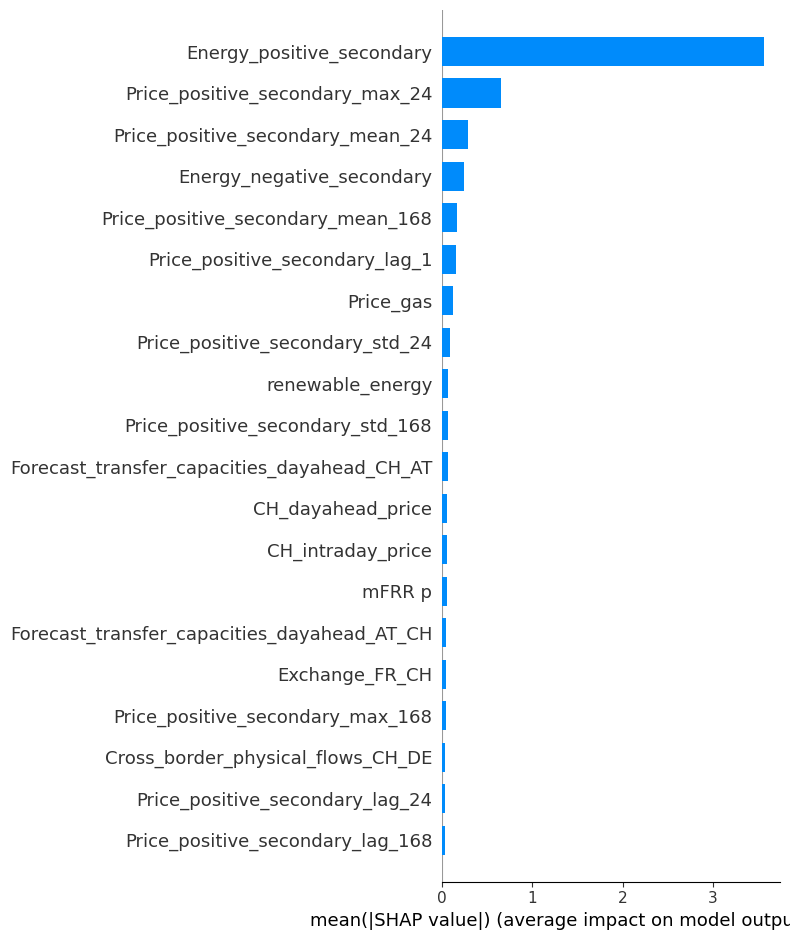

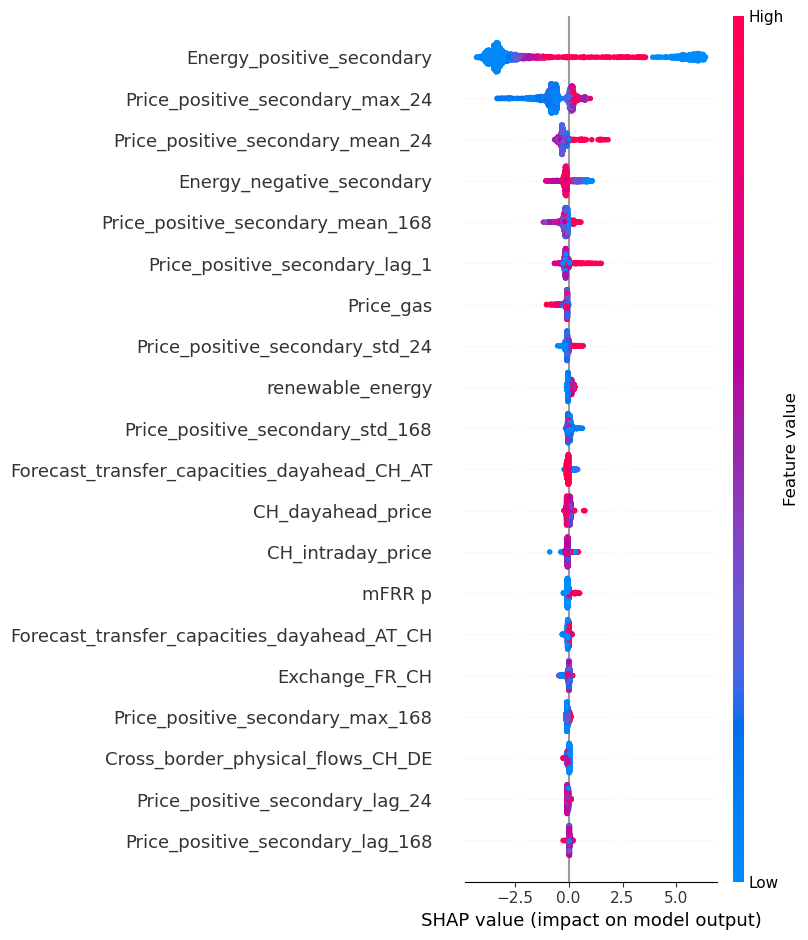

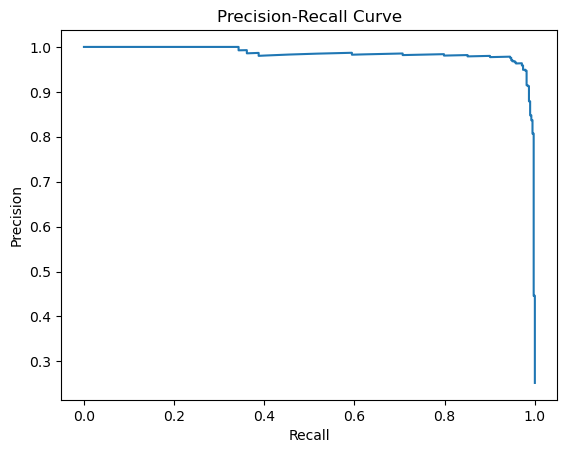


=== Price_negative_secondary ===
 Precision: 0.808  Recall: 0.621  F1: 0.702
 BalancedAcc: 0.801  McFaddenR²: 0.959  TjurR²: 0.535


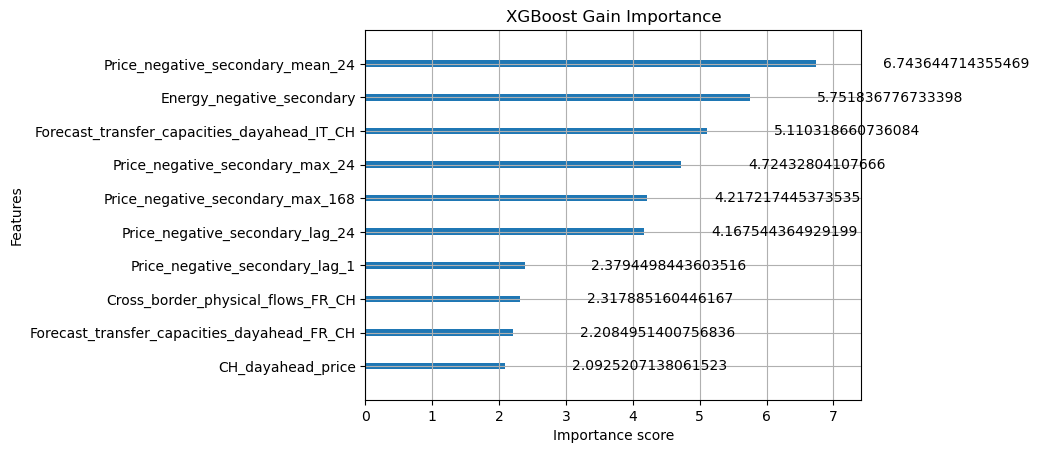

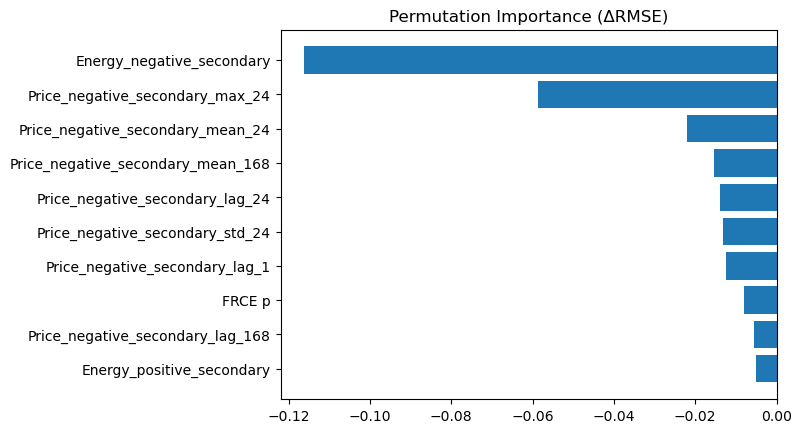

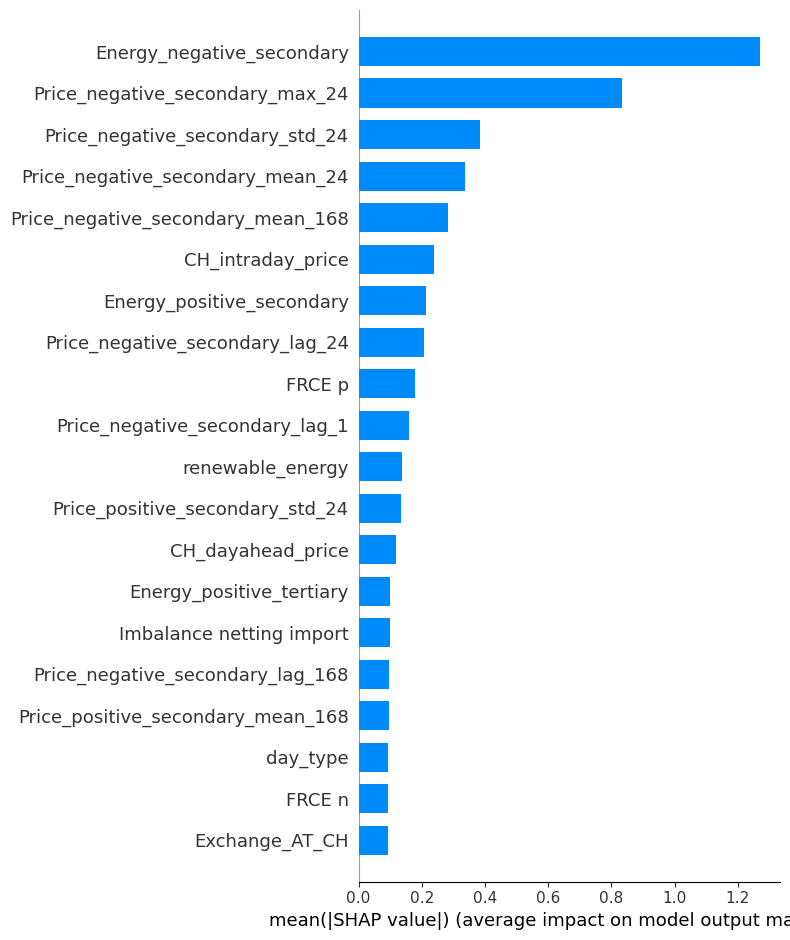

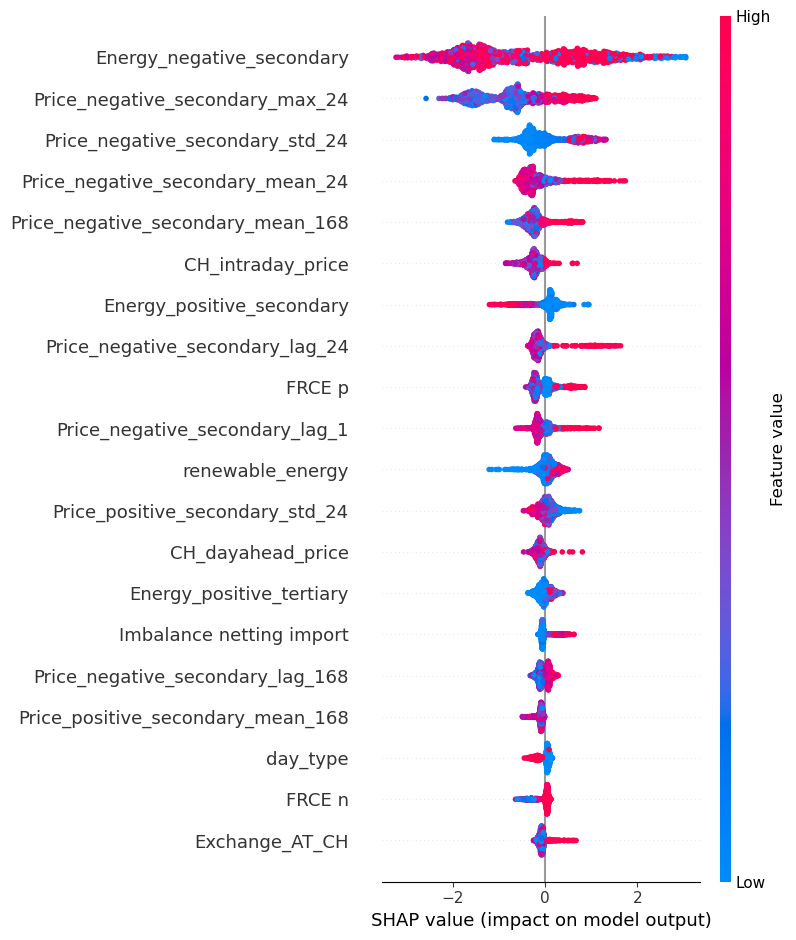

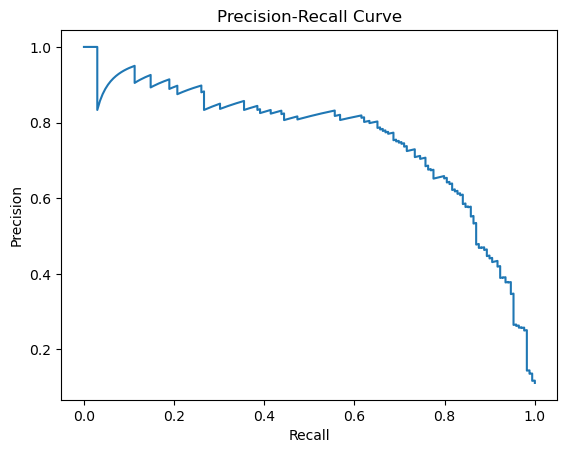


=== Price_positive_tertiary ===
 Precision: 0.995  Recall: 0.982  F1: 0.988
 BalancedAcc: 0.987  McFaddenR²: 0.997  TjurR²: 0.947


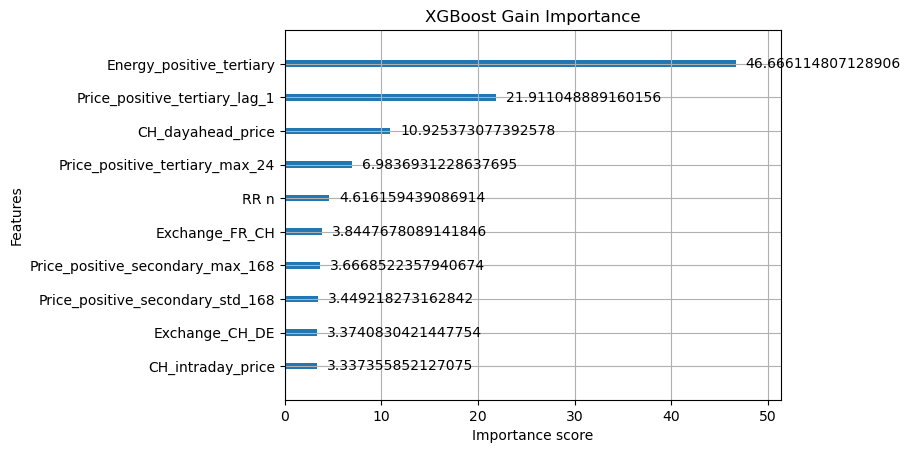

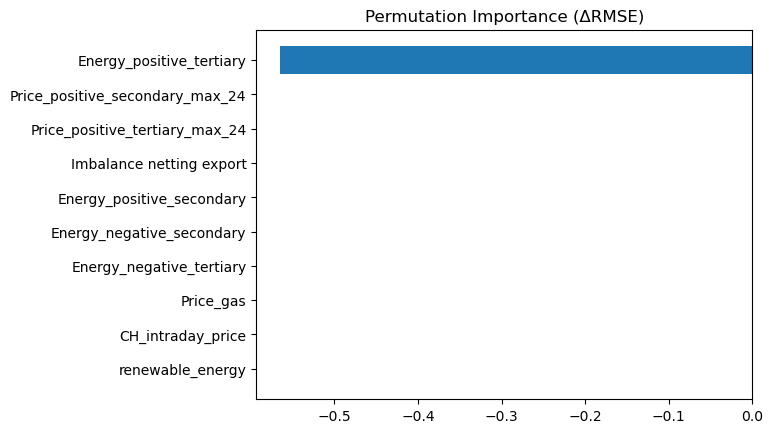

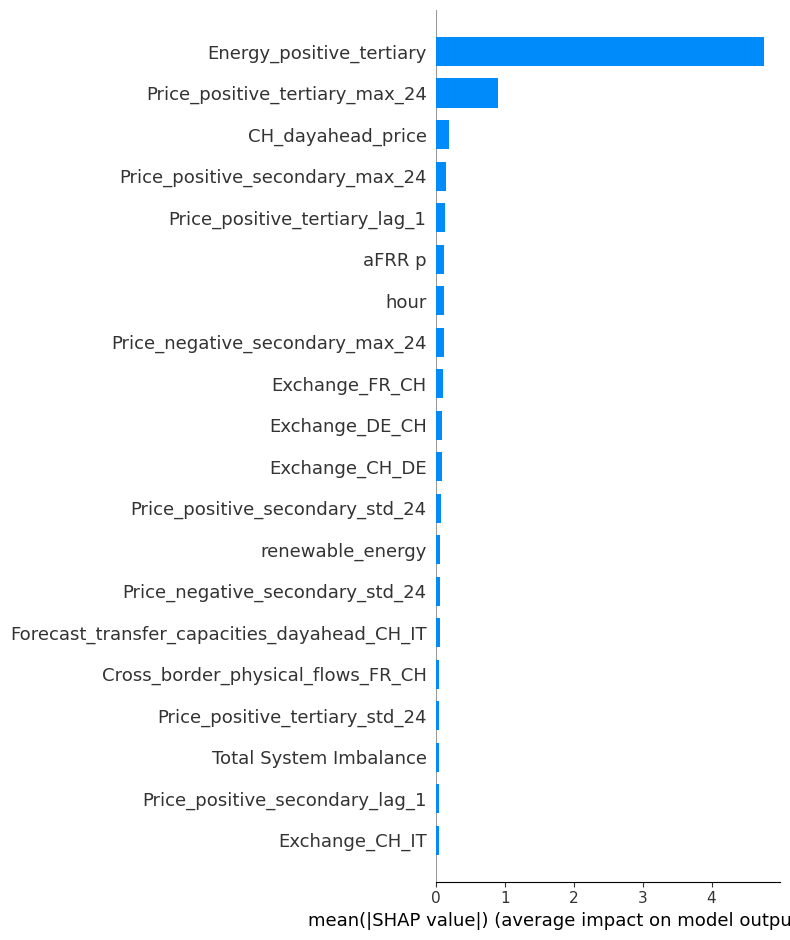

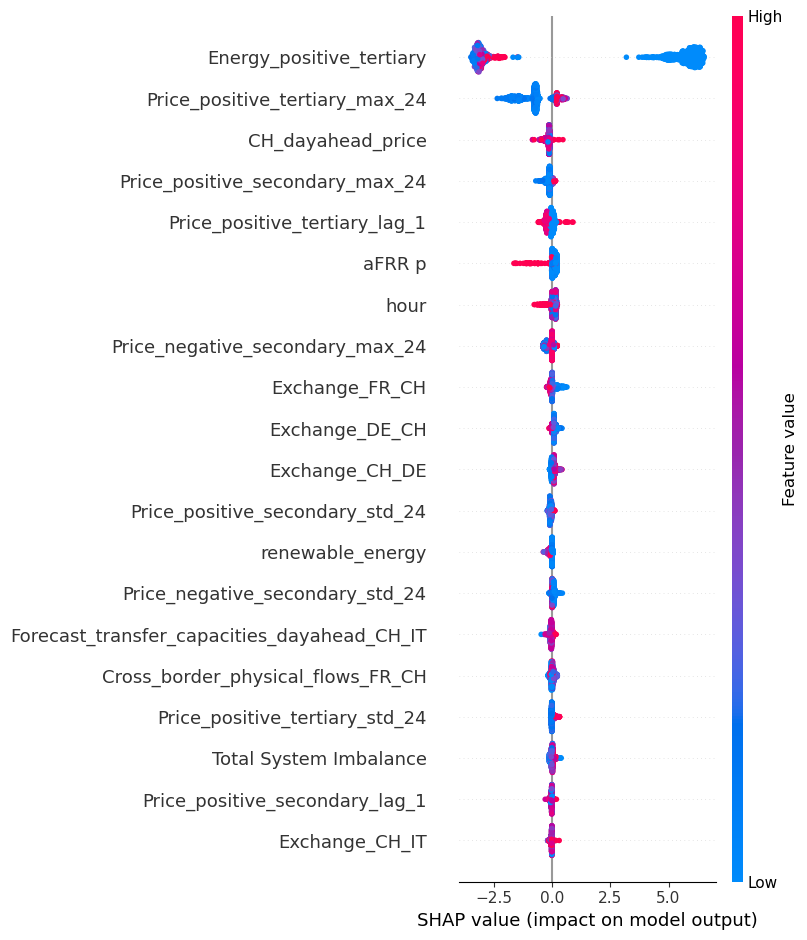

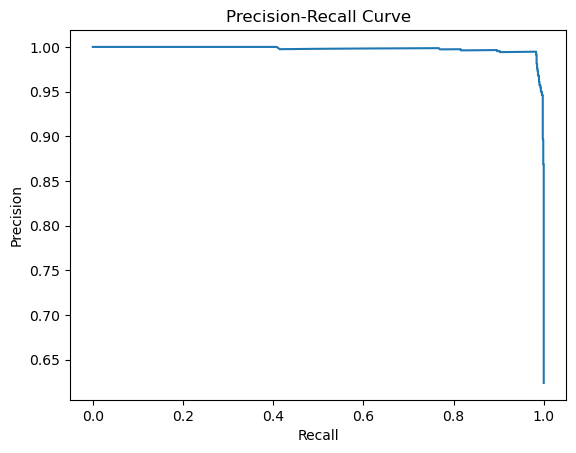


=== Price_negative_tertiary ===
 Precision: 0.989  Recall: 0.984  F1: 0.987
 BalancedAcc: 0.981  McFaddenR²: 0.998  TjurR²: 0.917


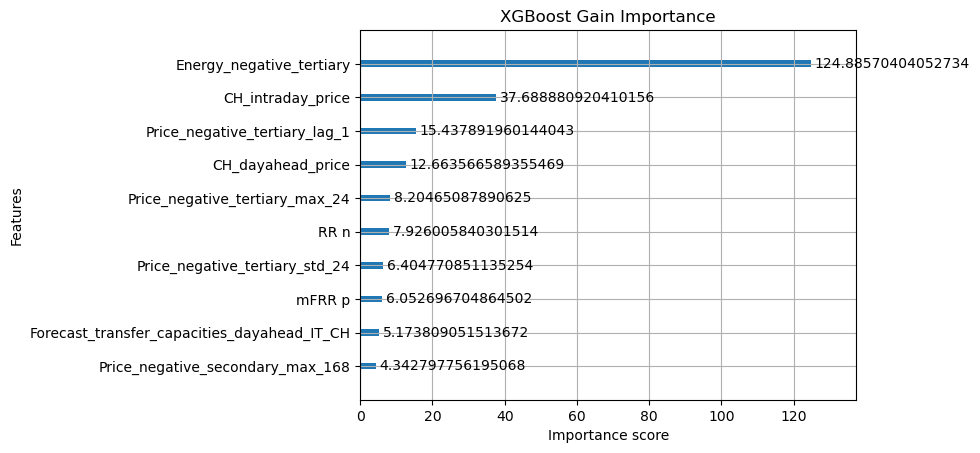

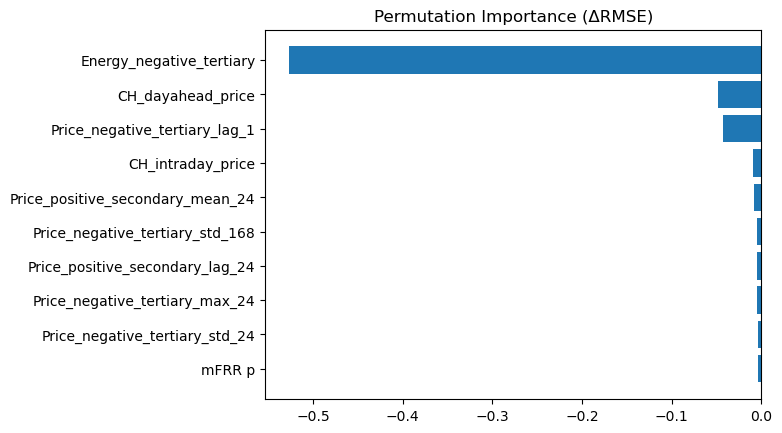

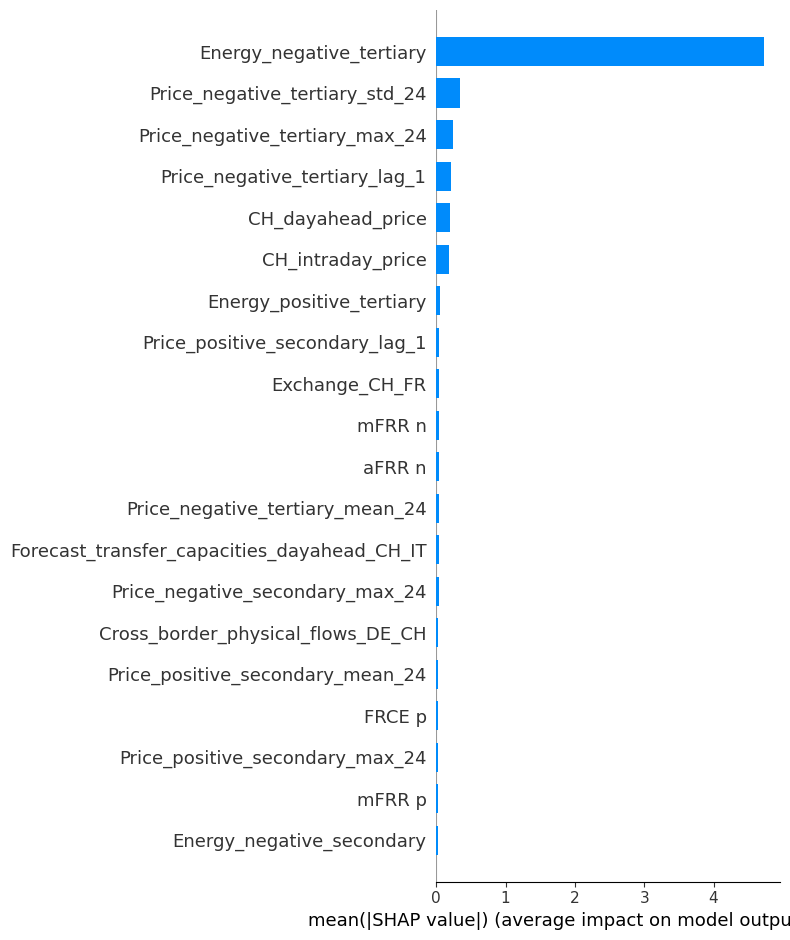

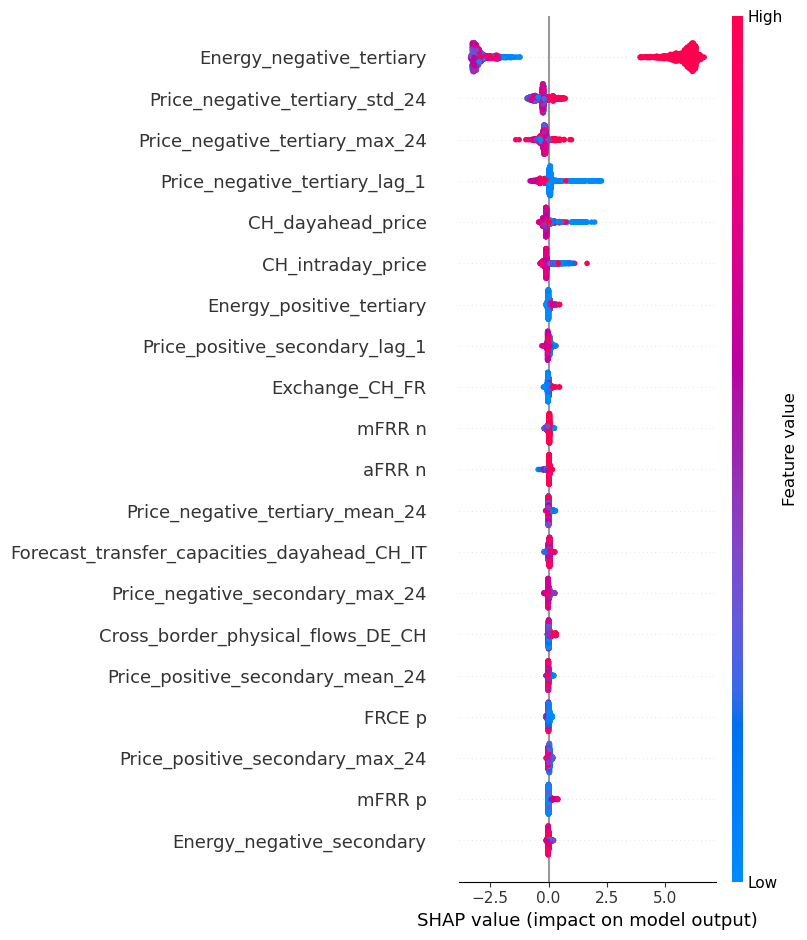

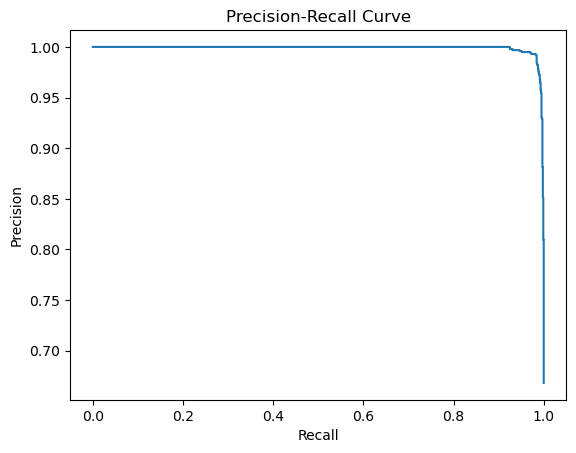

In [32]:
evaluate_all(best_fixed)

# Save model

## Helper

In [ ]:
def _json_ready(v):
    if isinstance(v, (np.integer, np.bool_)):  return int(v)
    if isinstance(v, (np.floating,)):          return float(v)
    if isinstance(v, (np.ndarray, list, tuple)): return np.asarray(v).tolist()
    if isinstance(v, pd.Series):               return v.tolist()
    return v              

# ── SAVE ────────────────────────────────────────────────────────────
def save_best_folds(
        best_folds: dict,
        folder: str = OUT_DIR,
        tag: str | None = None            # <-- optional differentiator
    ) -> None:
    """
    Saves each model as:
        <folder>/<tag>_<target>.model.json
        <folder>/<tag>_<target>.metrics.json
    If `tag` is None, files are just <target>.model.json etc.
    """
    os.makedirs(folder, exist_ok=True)

    for tgt, fold in best_folds.items():
        base_name = f"{tag}_{tgt}" if tag else tgt
        base_path = os.path.join(folder, base_name)

        fold["model"].save_model(base_path + ".model.json")

        meta = {k: _json_ready(v)
                for k, v in fold.items()
                if k not in ("model", "X_tr", "X_va")}
        with open(base_path + ".metrics.json", "w") as fp:
            json.dump(meta, fp, indent=2)

        print("✔ saved", base_name)

# ── LOAD ────────────────────────────────────────────────────────────
def load_best_folds(
        folder: str = OUT_DIR,
        tag: str | None = None
    ) -> dict:
    """
    Loads models that match the optional `tag`.
      • tag=None  -> all files in folder
      • tag='fixed' -> only files starting with 'fixed_'
    Returns {target: fold_dict}
    """
    out = {}
    for file in os.listdir(folder):
        if not file.endswith(".model.json"):
            continue
        if tag and not file.startswith(f"{tag}_"):
            continue

        base = file[:-11]                    # strip ".model.json"
        tgt  = base if not tag else base[len(tag)+1:]  # remove tag_
        clf  = xgb.XGBClassifier()
        clf.load_model(os.path.join(folder, file))

        with open(os.path.join(folder, base + ".metrics.json")) as fp:
            meta = json.load(fp)

        out[tgt] = {**meta, "model": clf}

    return out


## Saving models

In [ ]:
save_best_folds(best_fixed, folder=OUT_DIR, tag="fixed")
save_best_folds(best_rolling, folder=OUT_DIR, tag="rolling")
save_best_folds(best_dynamic, folder=OUT_DIR, tag="dynamic")

✔ saved fixed_Price_positive_secondary
✔ saved fixed_Price_negative_secondary
✔ saved fixed_Price_positive_tertiary
✔ saved fixed_Price_negative_tertiary
✔ saved rolling_Price_positive_secondary
✔ saved rolling_Price_negative_secondary
✔ saved rolling_Price_positive_tertiary
✔ saved rolling_Price_negative_tertiary
✔ saved dynamic_Price_positive_secondary
✔ saved dynamic_Price_negative_secondary
✔ saved dynamic_Price_positive_tertiary
✔ saved dynamic_Price_negative_tertiary
0.9633507853403142


In [ ]:

best_folds = load_best_folds(folder=OUT_DIR, tag="fixed")
print(best_folds["Price_positive_secondary"]["f1"])

# Model comparisons